# Table of Contents

In [1]:
from PIL import Image
import scipy.misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

In [2]:
from matplotlib.font_manager import FontProperties
def display_image_samples(data, labels=None): # labels are used for plot titles and are optional
    
    font = FontProperties()
    font.set_family('monospace')
    
    plt.figure(figsize=(8,4))
    rows, cols = 2, 4 # these are arbitrary
    random_ids = random.sample(range(len(data)), rows*cols) # randomly select the images
    
    for i in range(rows*cols):

        curr_index = random_ids[i]
        image = data[curr_index]
        title_str = ('shape: ' + str(image.shape))
        
        if labels:
            title_str += ('\nclass ' + str(labels[i]))
        
        plt.subplot(rows, cols, i+1)
        plt.title(title_str, fontproperties=font)
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Fetch Data

In [3]:
# increase the amount of data by applying rotation
def augment_data(data_path, k):
    
    # remove previous images, if any
    os.system('find ' + data_path + ' -name \'*-new*\' -delete')

    for k in range(NUM_CLASSES):
        curr_dir_path = data_path + 'c' + str(k) + '/'

        for file in os.listdir(curr_dir_path):

            file_name = os.fsdecode(file)
            
            # for each image found, generate a rotated copy
            if file_name.endswith(".jpg"):

                file_path = (os.path.join(curr_dir_path, file_name))

                new_file_name = os.path.splitext(file_name)[0] + '-new.jpg'
                
                rotation_degree = 0
                while rotation_degree == 0:
                    rotation_degree = random.randint(-10, 10)

                image = Image.open(file_path)
                new_image = image.rotate(rotation_degree, resample=Image.BICUBIC)
                new_image.save(curr_dir_path + new_file_name, 'JPEG')

In [4]:
def clean_data(data):
    
    cropped_data = []
    
    # resize images
    baseheight = 24
    for i, row in enumerate(data):
        image = Image.fromarray(row)
        hpercent = (baseheight / float(image.size[1]))
        wsize = int((float(image.size[0]) * float(hpercent)))
        image = image.resize((wsize, baseheight), Image.ANTIALIAS)
        cropped_data.append(np.asarray(image))
    
    data = np.asarray(cropped_data)
    
    # apply greyscale
    data = data.mean(3) # dimension 3 of image shape corresponds to color channels
    # data = data[:, :, :, 0] # same as above
    
    # center-crop images
    data = data[:, :, 7:data.shape[2]-1]
    
    print(data.shape)
    
    return data

In [5]:
from sklearn.model_selection import train_test_split
def load_data(data_path, k, test_size=0.3):
    
    # augment data by generating more images
    # augment_data(data_path, k)

    x = []
    y = []

    for i in range(k):
        curr_dir_path = data_path + 'c' + str(i) + '/'

        for file in os.listdir(curr_dir_path):
            file_name = os.fsdecode(file)

            if file_name.endswith(".jpg"):
                file_path = (os.path.join(curr_dir_path, file_name))
                img = np.asarray(Image.open(file_path))#.flatten()
                x.append(img)
                y.append(i)
                
    
    # apply greyscale and cropping
    x = clean_data(np.asarray(x))
    
    # np.asarray(x_train), np.asarray(labels)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

    return x_train, y_train, x_test, y_test

# Implementation

In [6]:
csv_path = '../dataset/driver_imgs_list.csv'
train_data_path = '../dataset/samples/'

drivers_csv = pd.read_csv(csv_path)
classes = (np.unique(np.asarray(drivers_csv)[:,1]))
NUM_CLASSES = len(classes) # 10

# fetch images from stored dataset in path
x_train, y_train, x_test, y_test = load_data(train_data_path, NUM_CLASSES) # test perc = 0.3 (default)

(20, 24, 24)


(13, 24, 24)


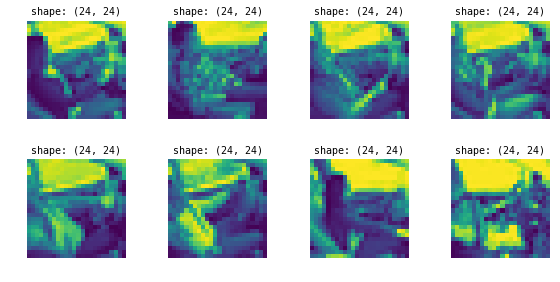

In [7]:
print(x_train.shape)

# print a sample of images
display_image_samples(x_train)

# Convolutional Neural Network

In [8]:
def conv_net(names, data, labels, num_epochs):  
    
    def conv_layer(x, W, b):
        conv = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")
        conv_with_b = tf.nn.bias_add(conv,b)
        conv_out = tf.nn.relu(conv_with_b)
        
        return conv_out
    
    def maxpool_layer(conv, k=2):
        return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    
    def model(x):
        #Define all needed variables
        W1 = tf.Variable(tf.random_normal([5,5,1,64]))
        b1 = tf.Variable(tf.random_normal([64]))

        W2 = tf.Variable(tf.random_normal([5,5,64,64]))
        b2 = tf.Variable(tf.random_normal([64]))

        W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
        b3 = tf.Variable(tf.random_normal([1024]))

        W_out = tf.Variable(tf.random_normal([1024, len(names)]))
        b_out = tf.Variable(tf.random_normal([len(names)]))
    
        #Define the actual model
        x_reshaped = tf.reshape(x, shape=[-1,24,24,1])
        
        #1: conv + pool layer 
        conv_out1 = conv_layer(x_reshaped, W1, b1)
        maxpool_out1 = maxpool_layer(conv_out1)
        norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
        
        #2: conv + pool layer
        conv_out2 = conv_layer(norm1, W2, b2)
        norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
        maxpool_out2 = maxpool_layer(norm2)
        
        #3: Fully connected layer 
        maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
        local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
        local_out = tf.nn.relu(local)
        
        #Obtain the final predition
        out = tf.add(tf.matmul(local_out, W_out), b_out)
                
        return out
    
    def run_model():
        #Define the x and y placeholders
        x = tf.placeholder(tf.float32, [None, 24*24])
        y = tf.placeholder(tf.float32, [None, len(names)])
        
        #Run the model
        y_predicted = model(x)
        
        # Define the cost
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=y_predicted, labels=y)
        )
        
        #Get the optimizer
        train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)
        
        #Train the Model
        with tf.Session() as s:
            s.run(tf.global_variables_initializer())
            onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
            onehot_vals = s.run(onehot_labels)
            batch_size = len(data) // 1
            print("batch_size", batch_size)
            
            for j in range(0, num_epochs):
                print("EPOCH #:", j)
                total_cost = 0
                for i in range(0, len(data), batch_size):
                    batch_data = data[i:i+batch_size, :]
                    batch_onehot_vals = onehot_vals[i:i+batch_size, :]
                    _, c = s.run([train_op, cost], feed_dict={x: batch_data, y: batch_onehot_vals})
                    total_cost += c
                    if i % 1000 == 0:
                        print("batch:",i, "cost:",total_cost)
                print("EPOCH #",j," END (Cost =",total_cost,")")
                
        #Obtain the accuracy on the trained model
        correct_pred = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        with tf.Session() as s:
            s.run(tf.global_variables_initializer())
            accuracy_val = s.run(accuracy,feed_dict={x: data, y:onehot_vals})
            print("ACCURACY = ", accuracy_val*100, "%")

    run_model()

In [9]:
# SIZES: names:[] x 10 , data:(50000, 576), labels:(50000,)
# conv_net(names, data, labels, num_epochs)

names = classes
data = x_train.reshape([len(x_train), len(x_train[0])**2])
labels = np.array(y_train)
print(names)
print(data.shape)
print(labels.shape)
conv_net(names, data, labels, 10)

['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']
(13, 576)
(13,)
batch_size 13
EPOCH #: 0
batch: 0 cost: 19958.0214844
EPOCH # 0  END (Cost = 19958.0214844 )
EPOCH #: 1
batch: 0 cost: 13403.7705078
EPOCH # 1  END (Cost = 13403.7705078 )
EPOCH #: 2
batch: 0 cost: 8985.10253906
EPOCH # 2  END (Cost = 8985.10253906 )
EPOCH #: 3
batch: 0 cost: 7685.75341797
EPOCH # 3  END (Cost = 7685.75341797 )
EPOCH #: 4
batch: 0 cost: 6252.65527344
EPOCH # 4  END (Cost = 6252.65527344 )
EPOCH #: 5
batch: 0 cost: 3943.78369141
EPOCH # 5  END (Cost = 3943.78369141 )
EPOCH #: 6
batch: 0 cost: 2035.66162109
EPOCH # 6  END (Cost = 2035.66162109 )
EPOCH #: 7
batch: 0 cost: 1593.88745117
EPOCH # 7  END (Cost = 1593.88745117 )
EPOCH #: 8
batch: 0 cost: 1520.7512207
EPOCH # 8  END (Cost = 1520.7512207 )
EPOCH #: 9
batch: 0 cost: 1761.90576172
EPOCH # 9  END (Cost = 1761.90576172 )
ACCURACY =  15.3846159577 %
